<a href="https://colab.research.google.com/github/panco17/test_1007/blob/main/6.2.%20soynlp%EB%A1%9C%20%EB%AA%85%EC%82%AC%EC%B6%94%EC%B6%9C%ED%95%B4%EC%84%9C%20%EC%9B%8C%EB%93%9C%ED%81%B4%EB%9D%BC%EC%9A%B0%EB%93%9C%20%EA%B7%B8%EB%A6%AC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pytextbook/pytextbook/blob/main/6.2.%20soynlp로%20명사추출해서%20워드클라우드%20그리기.ipynb)


# soynlp로 명사추출해서 워드클라우드 그리기
* soynlp(https://github.com/lovit/soynlp)로 토큰화하고 명사를 추출해 워드클라우드 그려보기

In [2]:
!pip install soynlp # 한국어 택스트 전처리 패키지
!pip show soynlp # 패키지 정보 확인
!pip install wordcloud #워드클라우드 시각화
!pip install koreanize-matplotlib #한국어 폰트

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 31.1 MB/s eta 0:00:00
Name: soynlp
Version: 0.0.493
Summary: Unsupervised Korean Natural Language Processing Toolkits
Home-page: https://github.com/lovit/soynlp
Author: Lovit
Author-email: soy.lovit@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, psutil, scikit-learn, scipy
Required-by: 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import koreanize_matplotlib
import os
import platform
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [4]:
base_path = "data"
file_name = "petition.csv" # 저장할 파일 이름
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'

def file_exist_check(base_path, file_name): # 파일존재 확인 없으면 다운로드
    if os.path.exists(f"./{file_name}"): #존재하는지
        print(f"{os.getcwd()}/{base_path} 경로에 파일이 있음")
        return

    if not os.path.exists(base_path):
        os.makedirs(base_path) #존재 x시 디랙토리 생성

    if platform.system() == "Linux":
        # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증하기
        !pip install -U -q PyDrive
        from pydrive.auth import GoogleAuth
        from pydrive.drive import GoogleDrive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
         # Google Drive 인증
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)

        id = url.split('=')[1]
        downloaded = drive.CreateFile({'id':id})
        downloaded.GetContentFile(f'{base_path}/{file_name}')
        print(f"사용자의 구글 드라이브에 {base_path}/{file_name} 다운로드 완료")
    else: #리눅스가 아닌 환경
        print(f"{url} 에서 다운로드 받아 실습 경로 {os.getcwd()}/{base_path}에 옮겨주세요.""")
        return

file_exist_check(base_path, file_name)

사용자의 구글 드라이브에 data/petition.csv 다운로드 완료


# 데이터 불러오기
*  데이터 출처 : https://github.com/akngs/petitions

In [5]:
df = pd.read_csv(f"{base_path}/petition.csv", index_col="article_id",
                        parse_dates=['start', 'end']) #파일의 경로 / article_id를 인덱스로 /
df.shape

# petition.csv

(377756, 7)

In [6]:
df.shape

(377756, 7)

In [7]:
df.tail()

,start,end,answered,votes,category,title,content
article_id,,,,,,,
492039,2019-01-09,2019-02-08,0,48,인권/성평등,박종철 의원. 폭행구속수사 및 의원직 박탈 청원합니다,나라돈으로 해외연수가서 현지 동반 가이드를 때려 안경 파편이 얼굴이 꽂혔답니다. C...
492040,2019-01-09,2019-02-08,0,5,정치개혁,각 정상들은 들으시요 국회의원을 학력과 무관한 양심 및 윤리가 있는 서민이 되어...,각 정당은 현재 국회의원 개개인을 심사하면 지탄받은 사람이 국\n회를 장악하고 있습...
492041,2019-01-09,2019-02-08,0,1,외교/통일/국방,남한땅에 옥류관을 오픈해주세요,말그대로 옥류관을 여기서 열면 진짜 재미있고 신나는 일이 일어날것 같은 느낌이 듭니...
492042,2019-01-09,2019-02-08,0,4,정치개혁,임종석실장님 수고많으셨습니다.,범죄정권이후 많은 어려움을 갖고 시작한 국민의정부.\n저급한 자칭 보수단체와 한국당...
492043,2019-01-09,2019-02-08,0,1,행정,예천군과 환경부를 규탄합니다. 어불성설인 가축사육 관련 법규를 개정해주세요!,해당 사건이 발생한 곳은 요즘은 매체에서 매일 나오는 곳으로 '군의원의 외유성 해외...


## 자신의 관심사에 맞는 단어로 데이터를 가져온다.

In [8]:
p = r'.*(돌봄|육아|초등|보육).*'
care = df[df['title'].str.match(p) |
           df['content'].str.match(p, flags=re.MULTILINE)]
care.shape

(14960, 7)

In [9]:
care.head(2)

,start,end,answered,votes,category,title,content
article_id,,,,,,,
24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
36,2017-08-19,2017-08-26,0,1,인권/성평등,한국채식인구 100만명. 학교 급식 및 군대에서 현미채식 선택권을 보장해주십시오!,문재인 대통령님과 각 정부 인사분들께 마음속 깊이 존경과 감사를 표합니다. 대한민국...


In [10]:
sample_index = 24


In [11]:
sample_title = care.loc[sample_index, 'title']
sample_title

'공공기관 무조건적인 정규직전환을 반대합니다.'

### sample_content 내용 확인

In [12]:
sample_content = care['content'][sample_index]
sample_content

'현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인맥으로 들어온 경우가 많습니다. 자질이 안되는데도 정규직이 된다면 그 피해는 국민들에게 돌아갈것입니다. 현재 공공기관 정규직들은 100대1의 경쟁률을 뚫고 들어온 경우도 있습니다. 지금도 노량진에서 수많은 청춘들이 공부를 하고 있죠. 기존 비정규직들을 무조건적으로 무기직 전환한다면 또 다른 정유라 탄생이고 역차별입니다. 새로 필요로 하는 신규채용부터 공채절차를 거쳐 무기직 전환해야합니다. 예전에 공무원 기능직의 일반직 전환, 초등학교에 중초교사 임용 등이 그 예죠. 실제 일하는 곳에서는 그분들로 인한 업무처리 미흡으로 문제가 되고 있습니다. 사립학교는 인건비를 국가에서 주니 사립학교도 국가에서 공채해야 합니다. 부디 사례 하나하나를 보아가며 처리해주시고 전체 정규직 숫자 전환만 보며 공약실천을 무리하게 하지 말아주세요.  국민들은 정의로운 나라를 원합니다. 역차별이 아닌 공정한 채용이 되게 해주세요.'

## 토큰화

Soynlp에서 제공하는 RegexTokenizer를 사용하여 토큰화

# 토큰화

In [13]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer

/usr/local/lib/python3.10/dist-packages/soynlp/tokenizer/_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


In [14]:
tokened_title = tokenizer.tokenize(sample_title)
tokened_title

['공공기관', '무조건적인', '정규직전환을', '반대합니다', '.']

In [15]:
tokened_content = tokenizer.tokenize(sample_content)
tokened_content[:20]

['현정부에서',
 '정규직',
 '일자리를',
 '늘리는',
 '것에',
 '찬성합니다',
 '.',
 '그런데',
 '공공기관',
 '비정규직들은',
 '인맥으로',
 '들어온',
 '경우가',
 '많습니다',
 '.',
 '자질이',
 '안되는데도',
 '정규직이',
 '된다면',
 '그']

In [16]:
print(len(tokened_title))
print(len(tokened_content))

5
125


# 텍스트 데이터 전처리
* 개행문자(줄바꿈 문자) 제거

In [17]:
content_text = care['content'].str.replace("\\\\n", " ", regex=True)
content_text = content_text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 a-zA-Z]", " ", regex=True)

In [18]:
content_text.head(2)

,content
article_id,
24,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다 그런데 공공기관 비정규직들은 인...
36,문재인 대통령님과 각 정부 인사분들께 마음속 깊이 존경과 감사를 표합니다 대한민국...


In [19]:
tokens = content_text.apply(tokenizer.tokenize)
tokens[:3]

,content
article_id,
24,"[현정부에서, 정규직, 일자리를, 늘리는, 것에, 찬성합니다, 그런데, 공공기관, ..."
36,"[문재인, 대통령님과, 각, 정부, 인사분들께, 마음속, 깊이, 존경과, 감사를, ..."
45,"[초등학교, 교사, 임용, 시험을, 수능, 시험, 처럼, 전국, 단위로, 실시하고난..."


In [20]:
tokens[sample_index][:10]

['현정부에서', '정규직', '일자리를', '늘리는', '것에', '찬성합니다', '그런데', '공공기관', '비정규직들은', '인맥으로']

## 워드 클라우드 그리기

In [21]:
!apt -qq -y install fonts-nanum
from wordcloud import WordCloud
import matplotlib.pyplot as plt


stopwords = ['하지만', '그리고', '그런데', '저는','제가',
             '그럼', '이런', '저런', '합니다',
             '많은', '많이', '정말', '너무']

def display_word_cloud(data, width=1200, height=500):

    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumGothic.ttf",
        width=width, height=height,
        stopwords=stopwords,
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


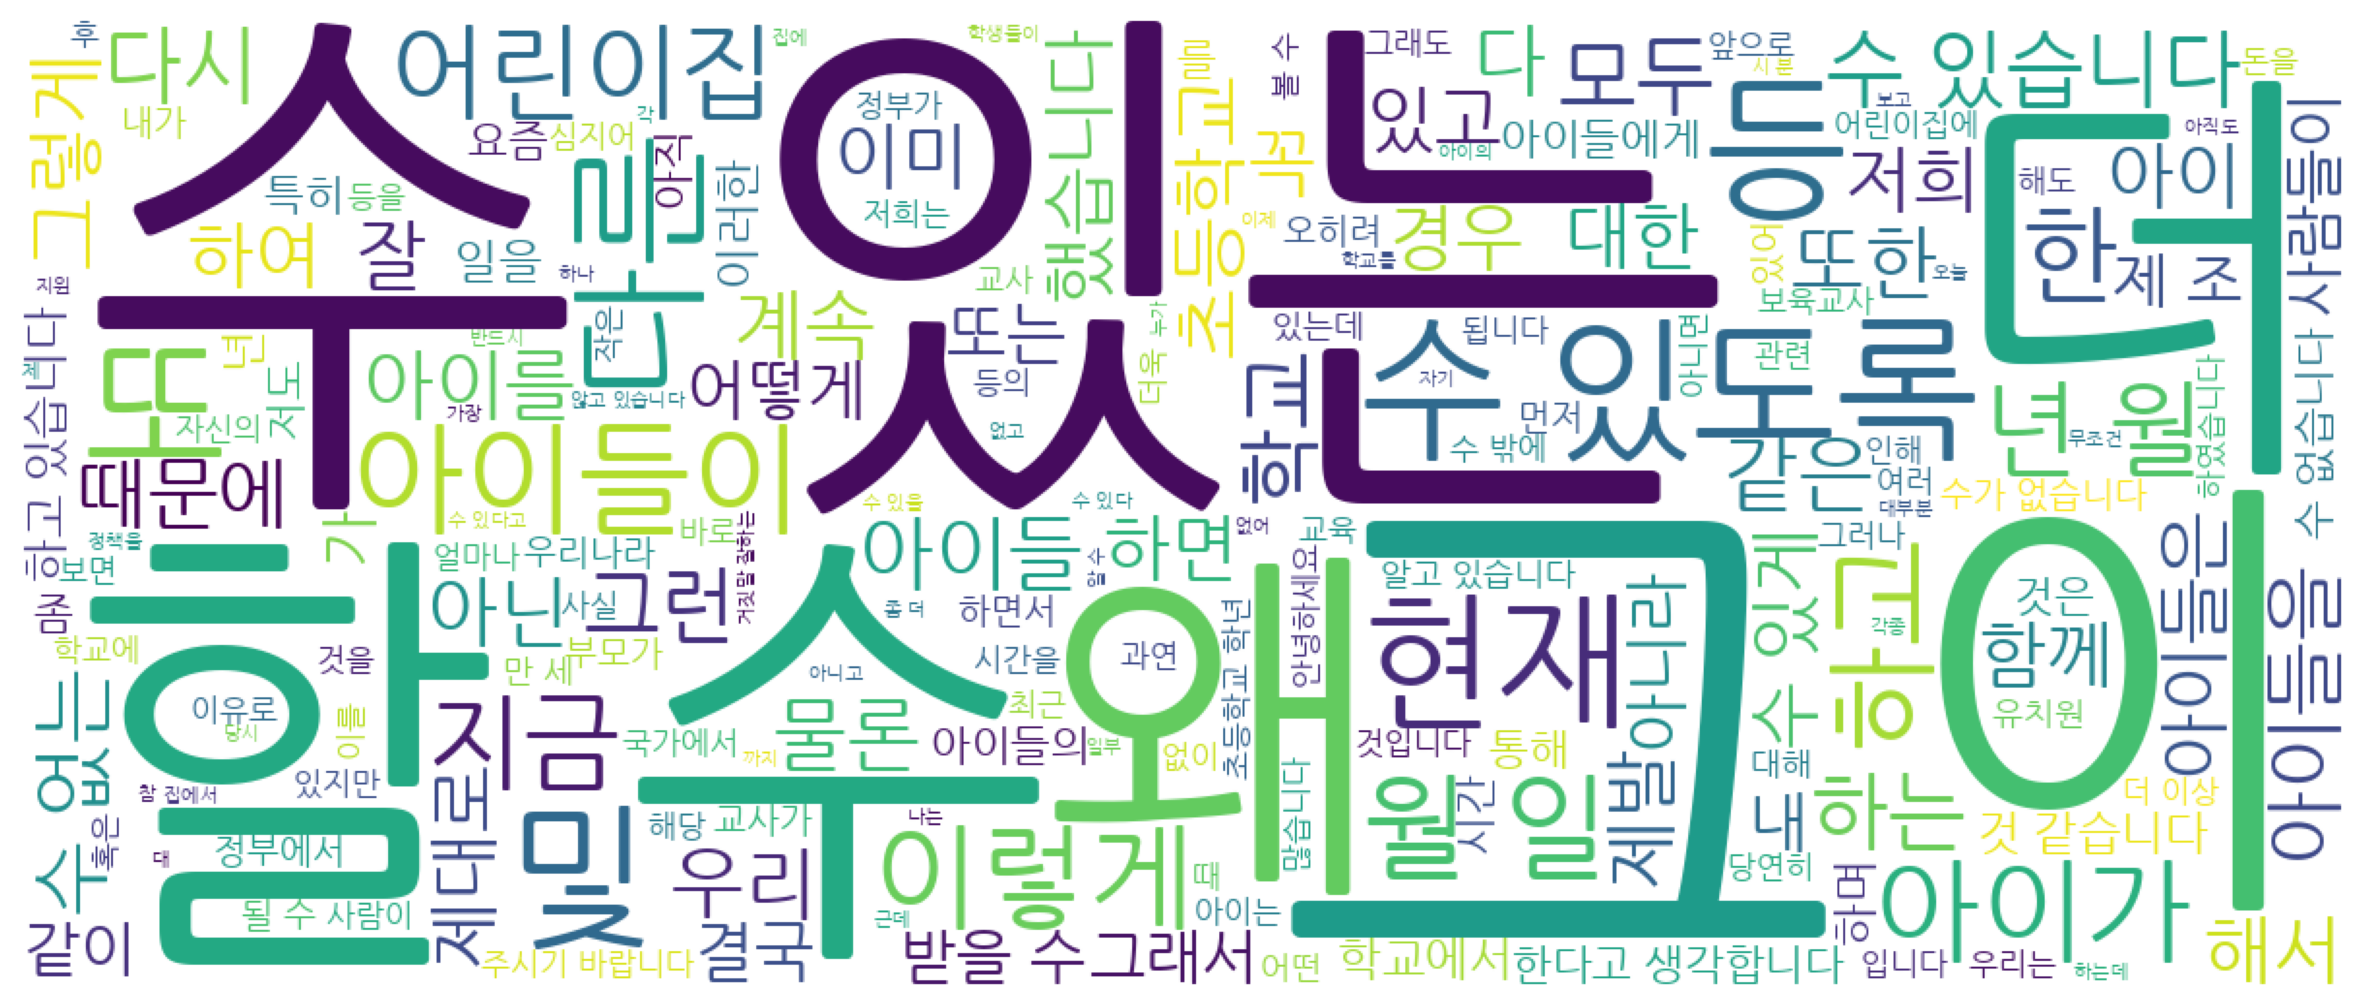

In [22]:
# display_word_cloud 함수 안에 font_path 위치
font_path=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
display_word_cloud(' '.join(content_text))

출력 결과를 보면 '수'나 '및'과 같이 문서의 의미를 특징 짓지 않는 불용어(STOPWORD)가 너무 많다는 것을 알 수 있다.


## 명사만 추출하여 시각화

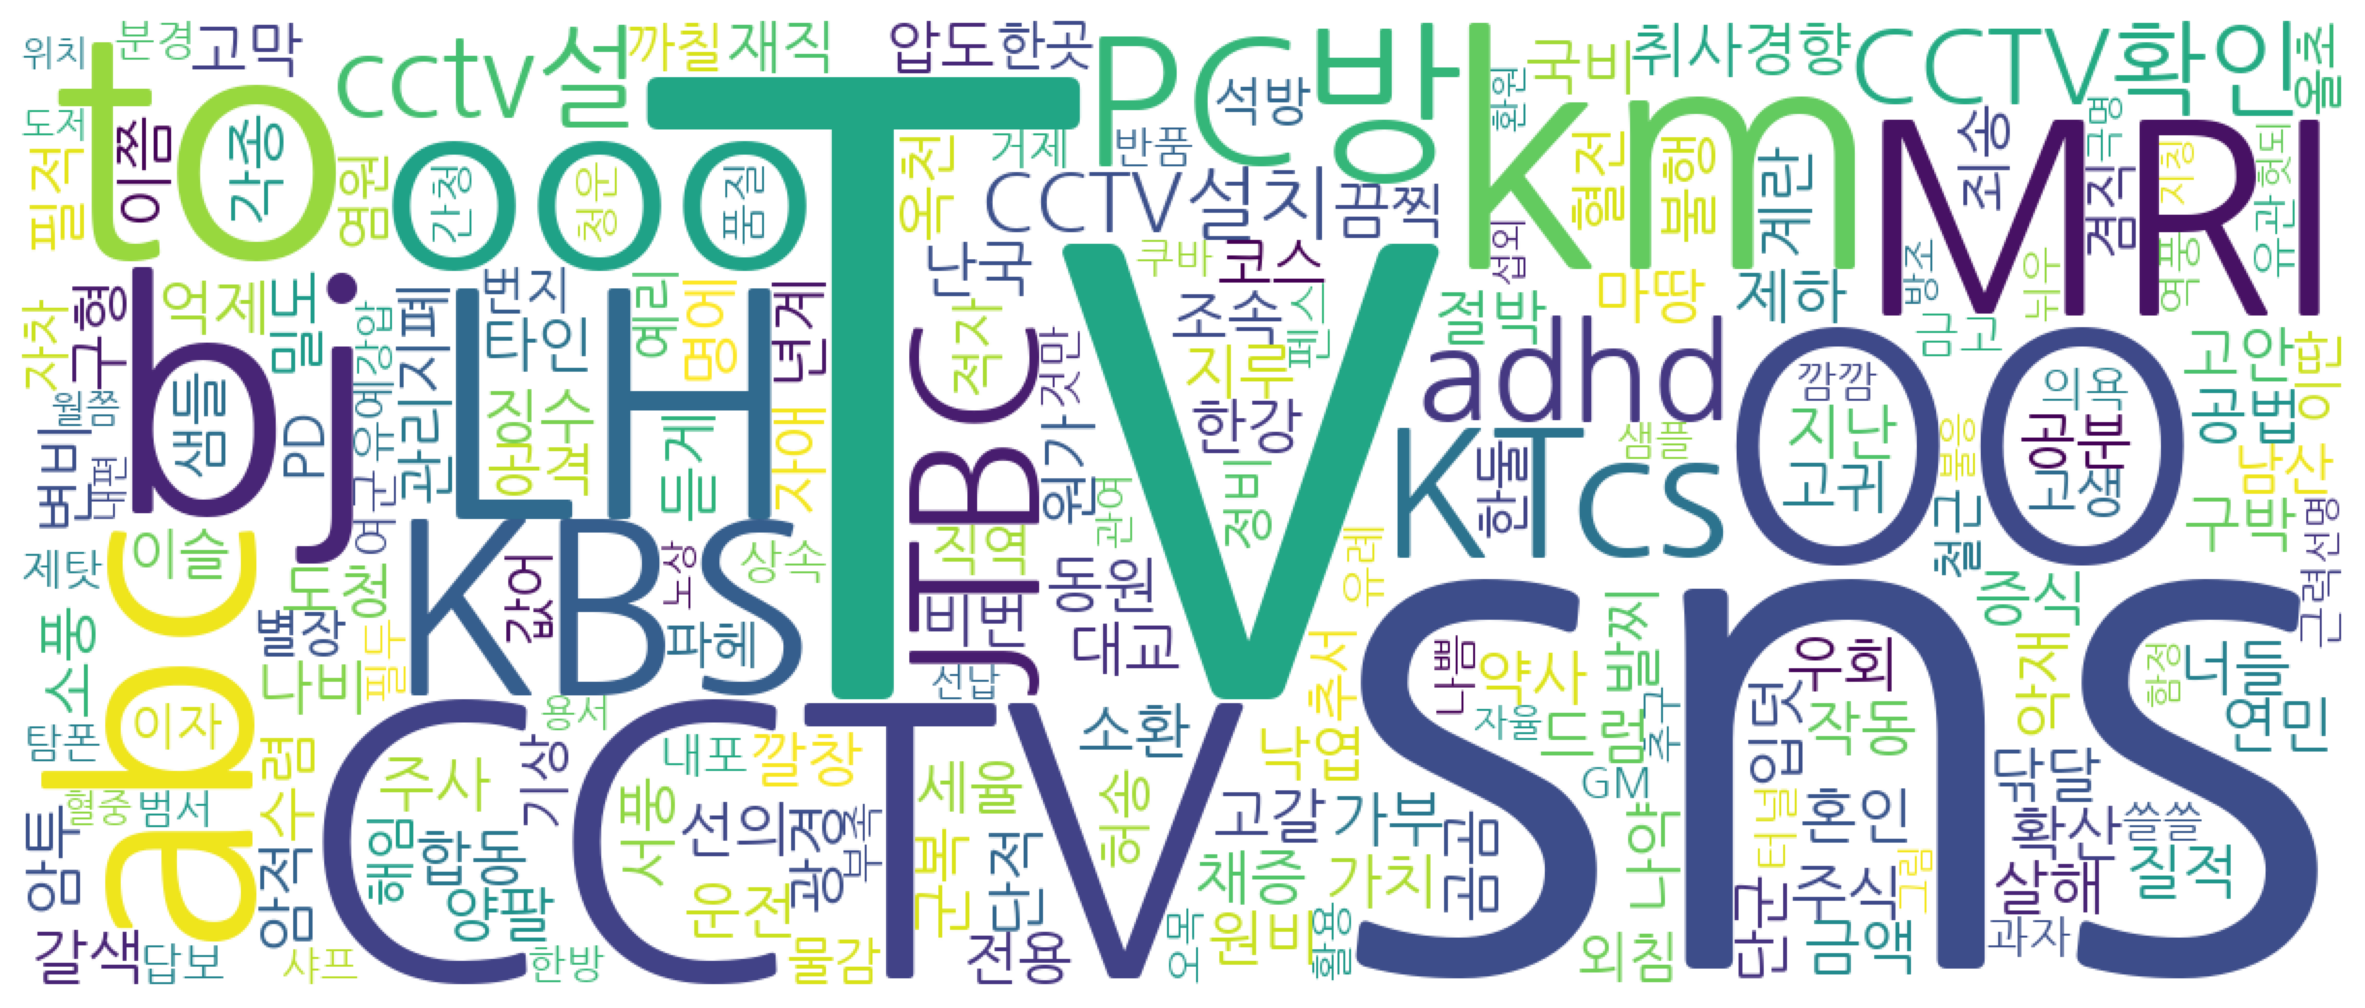

CPU times: user 3.68 s, sys: 376 ms, total: 4.06 s
Wall time: 4.05 s


In [26]:
# 추출된 명사를 워크 클라우드를 통해 시각화한다.
%time display_word_cloud(nouns_text)

In [23]:
from soynlp.noun import LRNounExtractor

In [24]:
%%time
noun_extractor = LRNounExtractor(verbose=True)
noun_extractor.train(content_text)
nouns = noun_extractor.extract()

[Noun Extractor] used default noun predictor; Sejong corpus predictor
[Noun Extractor] used noun_predictor_sejong
[Noun Extractor] All 2398 r features was loaded
[Noun Extractor] scanning was done (L,R) has (149911, 73537) tokens
[Noun Extractor] building L-R graph was done
[Noun Extractor] 25598 nouns are extracted
CPU times: user 1min 3s, sys: 422 ms, total: 1min 3s
Wall time: 1min 4s


In [25]:
nouns_text = " ".join(list(nouns.keys()))
nouns_text[:100]

'깔창 주식 조속 가부 선의 원비 대교 혼인 합동 공법 국비 도청 타인 질적 군복 절박 구박 너들 가치 드럼 억제 양팔 작동 운전 우회 변비 약사 나비 나약 낙엽 주사 지루 고안 연'